# Part I - Prosper Loan Data Exploration
### by Tristen Wallace

This project centers on analyzing a dataset from Prosper Marketplace, an online peer-to-peer lending company. The [original dataset](https://s3.amazonaws.com/udacity-hosted-downloads/ud651/prosperLoanData.csv) contains 113,937 loan listings, encompassing 81 different variables. These features range from loan amounts and borrower rates to current loan statuses and borrower incomes. For detailed explanations of these variables, a [data feature dictionary](https://www.google.com/url?q=https://docs.google.com/spreadsheet/ccc?key%3D0AllIqIyvWZdadDd5NTlqZ1pBMHlsUjdrOTZHaVBuSlE%26usp%3Dsharing&sa=D&ust=1554486256024000) is provided.

The exploration aims to investigate various features related to borrowers, loan listings, lender characteristics and the mentioned time periods. Our goal is to uncover how these elements affect the liklihood of defaulted and charged off loans, and to understand the impact of three major historical events: the 2008 Great Recession, the SEC's cease and desist order issued to Prosper Marketplace in November 2008, and the relaunch of Prosper post-SEC intervention in July 2009.

## 1. Preliminary Wrangling Assessment

In [416]:
# import all packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import custom_funcs

%matplotlib inline

In [417]:
# Load dataset
file_path = '../data/prosperLoanData.csv'
df = pd.read_csv(file_path)

#Data structure
print(df.shape)

#Preview data
df.sample(5)


(113937, 81)


,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,...,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
21184,48D6338305900775615C69F,111343,2007-03-15 06:40:42.023000000,C,36,Completed,2010-04-09 00:00:00,0.15713,0.1500,0.1400,...,-164.95,0.0,0.0,0.0,0.0,1.0,0,0,0.0,336
88295,F1CB3600303372328846B3C,1163415,2014-01-27 11:37:36.003000000,NaN,36,Current,NaN,0.06726,0.0605,0.0505,...,-9.53,0.0,0.0,0.0,0.0,1.0,0,0,0.0,1
16972,90C83591686852437DB7EE7,958225,2013-10-25 07:37:47.093000000,NaN,36,Current,NaN,0.19859,0.1620,0.1520,...,-24.65,0.0,0.0,0.0,0.0,1.0,0,0,0.0,1
104469,0F1135451959151161084CD,583772,2012-04-28 19:58:43.543000000,NaN,36,Current,NaN,0.15538,0.1270,0.1170,...,-45.58,0.0,0.0,0.0,0.0,1.0,0,0,0.0,52
76581,4FD435983989792826BEFA0,1089646,2014-01-07 07:53:46.970000000,NaN,36,Current,NaN,0.23131,0.1940,0.1840,...,-12.74,0.0,0.0,0.0,0.0,1.0,0,0,0.0,40


In [418]:
# Review variables
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113937 entries, 0 to 113936
Data columns (total 81 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   ListingKey                           113937 non-null  object 
 1   ListingNumber                        113937 non-null  int64  
 2   ListingCreationDate                  113937 non-null  object 
 3   CreditGrade                          28953 non-null   object 
 4   Term                                 113937 non-null  int64  
 5   LoanStatus                           113937 non-null  object 
 6   ClosedDate                           55089 non-null   object 
 7   BorrowerAPR                          113912 non-null  float64
 8   BorrowerRate                         113937 non-null  float64
 9   LenderYield                          113937 non-null  float64
 10  EstimatedEffectiveYield              84853 non-null   float64
 11  EstimatedLoss

In [419]:
# Review daterange
df.describe()


,ListingNumber,Term,BorrowerAPR,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperRating (numeric),ProsperScore,...,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
count,1.139370e+05,113937.000000,113912.000000,113937.000000,113937.000000,84853.000000,84853.000000,84853.000000,84853.000000,84853.000000,...,113937.000000,113937.000000,113937.000000,113937.000000,113937.000000,113937.000000,113937.000000,113937.000000,113937.000000,113937.000000
mean,6.278857e+05,40.830248,0.218828,0.192764,0.182701,0.168661,0.080306,0.096068,4.072243,5.950067,...,-54.725641,-14.242698,700.446342,681.420499,25.142686,0.998584,0.048027,0.023460,16.550751,80.475228
std,3.280762e+05,10.436212,0.080364,0.074818,0.074516,0.068467,0.046764,0.030403,1.673227,2.376501,...,60.675425,109.232758,2388.513831,2357.167068,275.657937,0.017919,0.332353,0.232412,294.545422,103.239020
min,4.000000e+00,12.000000,0.006530,0.000000,-0.010000,-0.182700,0.004900,-0.182700,1.000000,1.000000,...,-664.870000,-9274.750000,-94.200000,-954.550000,0.000000,0.700000,0.000000,0.000000,0.000000,1.000000
25%,4.009190e+05,36.000000,0.156290,0.134000,0.124200,0.115670,0.042400,0.074080,3.000000,4.000000,...,-73.180000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.000000
50%,6.005540e+05,36.000000,0.209760,0.184000,0.173000,0.161500,0.072400,0.091700,4.000000,6.000000,...,-34.440000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,44.000000
75%,8.926340e+05,36.000000,0.283810,0.250000,0.240000,0.224300,0.112000,0.116600,5.000000,8.000000,...,-13.920000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,115.000000
max,1.255725e+06,60.000000,0.512290,0.497500,0.492500,0.319900,0.366000,0.283700,7.000000,11.000000,...,32.060000,0.000000,25000.000000,25000.000000,21117.900000,1.012500,39.000000,33.000000,25000.000000,1189.000000


**Dimensionality Reduction:** We don't need many of these columns so we will create a subset with only the columns/features that interest us for this project.

In [420]:
# Varaibles of interest
cols = ['LoanStatus', 'Term', 'CreditGrade', 'BorrowerAPR',
        'ProsperRating (Alpha)', 'ListingCategory (numeric)', 'BorrowerState', 'Occupation', 'EmploymentStatus',
        'IsBorrowerHomeowner', 'GroupKey', 'DebtToIncomeRatio', 'IncomeRange', 'ListingNumber', 'ProsperPrincipalBorrowed',
        'ProsperPrincipalOutstanding', 'LoanOriginalAmount', 'LoanOriginationDate', 'MemberKey', 'InvestmentFromFriendsCount', 
        'InvestmentFromFriendsAmount', 'Investors']

df_sub = df[cols]

# Descriptive statistics
df_sub.describe()


,Term,BorrowerAPR,ListingCategory (numeric),DebtToIncomeRatio,ListingNumber,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,LoanOriginalAmount,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
count,113937.000000,113912.000000,113937.000000,105383.000000,1.139370e+05,22085.000000,22085.000000,113937.00000,113937.000000,113937.000000,113937.000000
mean,40.830248,0.218828,2.774209,0.275947,6.278857e+05,8472.311961,2930.313906,8337.01385,0.023460,16.550751,80.475228
std,10.436212,0.080364,3.996797,0.551759,3.280762e+05,7395.507650,3806.635075,6245.80058,0.232412,294.545422,103.239020
min,12.000000,0.006530,0.000000,0.000000,4.000000e+00,0.000000,0.000000,1000.00000,0.000000,0.000000,1.000000
25%,36.000000,0.156290,1.000000,0.140000,4.009190e+05,3500.000000,0.000000,4000.00000,0.000000,0.000000,2.000000
50%,36.000000,0.209760,1.000000,0.220000,6.005540e+05,6000.000000,1626.550000,6500.00000,0.000000,0.000000,44.000000
75%,36.000000,0.283810,3.000000,0.320000,8.926340e+05,11000.000000,4126.720000,12000.00000,0.000000,0.000000,115.000000
max,60.000000,0.512290,20.000000,10.010000,1.255725e+06,72499.000000,23450.950000,35000.00000,33.000000,25000.000000,1189.000000


In [421]:
# Rename variables
df_sub = df_sub.rename(columns={'ProsperRating (Alpha)':'ProsperRating',
                        'ListingCategory (numeric)':'ListingCategory'})

In [422]:
# Check for missing values
df_sub.isnull().sum().sort_values(ascending=False)

GroupKey                       100596
ProsperPrincipalOutstanding     91852
ProsperPrincipalBorrowed        91852
CreditGrade                     84984
ProsperRating                   29084
DebtToIncomeRatio                8554
BorrowerState                    5515
Occupation                       3588
EmploymentStatus                 2255
BorrowerAPR                        25
InvestmentFromFriendsAmount         0
InvestmentFromFriendsCount          0
MemberKey                           0
LoanOriginationDate                 0
LoanOriginalAmount                  0
LoanStatus                          0
ListingNumber                       0
IncomeRange                         0
Term                                0
IsBorrowerHomeowner                 0
ListingCategory                     0
Investors                           0
dtype: int64

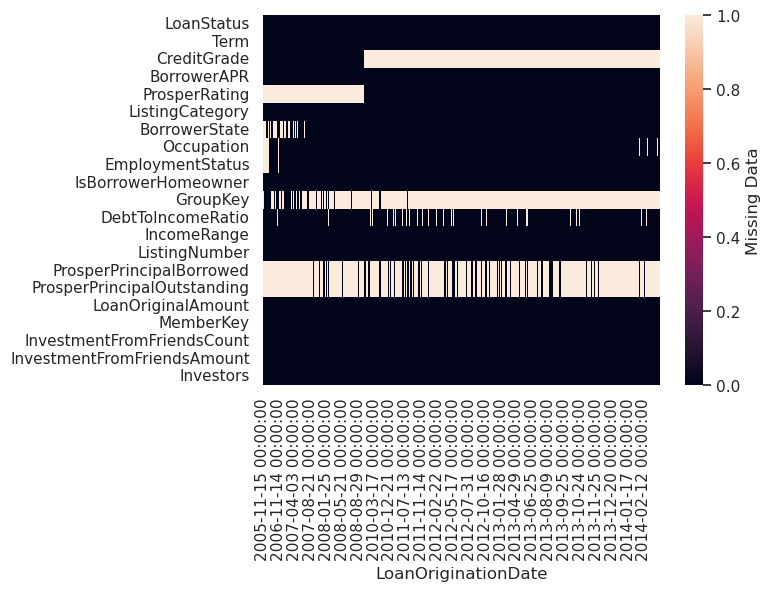

In [423]:
df.LoanOriginationDate = pd.to_datetime(df.LoanOriginationDate)
sns.heatmap(df_sub.set_index('LoanOriginationDate').sort_index().isna().transpose(),
            cbar_kws={'label':'Missing Data'});

In [424]:
# Descriptive statistics of loans where at least one friend invested
df_sub.query('InvestmentFromFriendsCount > 1').describe() 


,Term,BorrowerAPR,ListingCategory,DebtToIncomeRatio,ListingNumber,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,LoanOriginalAmount,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
count,296.000000,296.000000,296.000000,240.000000,2.960000e+02,72.000000,72.000000,296.000000,296.000000,296.000000,296.000000
mean,36.324324,0.176282,1.939189,0.450500,3.234413e+05,8323.430556,2286.484306,8362.452703,2.831081,1570.096655,145.716216
std,3.407303,0.085295,2.138355,1.408578,1.467491e+05,7449.745102,2900.049803,6726.983332,2.609990,2627.150381,126.895048
min,12.000000,0.056720,0.000000,0.010000,1.001990e+05,1000.000000,0.000000,1000.000000,2.000000,55.000000,2.000000
25%,36.000000,0.105910,0.000000,0.110000,2.293972e+05,2500.000000,0.000000,3181.250000,2.000000,221.832500,54.500000
50%,36.000000,0.158825,1.000000,0.215000,3.303085e+05,5225.000000,1160.355000,5750.000000,2.000000,551.980000,104.500000
75%,36.000000,0.223510,3.000000,0.350000,3.964090e+05,11250.000000,3544.612500,10500.000000,3.000000,1500.000000,207.000000
max,60.000000,0.374530,7.000000,10.010000,1.063442e+06,30000.000000,13568.900000,25000.000000,33.000000,23699.520000,667.000000


In [425]:
# Check unique income ranges
df_sub.IncomeRange.value_counts()

IncomeRange
$25,000-49,999    32192
$50,000-74,999    31050
$100,000+         17337
$75,000-99,999    16916
Not displayed      7741
$1-24,999          7274
Not employed        806
$0                  621
Name: count, dtype: int64

In [426]:
# Check counts for unique term lengths
df_sub.Term.value_counts()

Term
36    87778
60    24545
12     1614
Name: count, dtype: int64

In [427]:
# Check counts for unique loan statuses
df_sub.LoanStatus.value_counts()

LoanStatus
Current                   56576
Completed                 38074
Chargedoff                11992
Defaulted                  5018
Past Due (1-15 days)        806
Past Due (31-60 days)       363
Past Due (61-90 days)       313
Past Due (91-120 days)      304
Past Due (16-30 days)       265
FinalPaymentInProgress      205
Past Due (>120 days)         16
Cancelled                     5
Name: count, dtype: int64

In [428]:
# Check counts for unique employment statuses
df_sub.EmploymentStatus.value_counts()

EmploymentStatus
Employed         67322
Full-time        26355
Self-employed     6134
Not available     5347
Other             3806
Part-time         1088
Not employed       835
Retired            795
Name: count, dtype: int64

In [429]:
df_sub.query('EmploymentStatus == "Not available"')['IncomeRange']


2         Not displayed
17        Not displayed
42        Not displayed
63        Not displayed
76        Not displayed
              ...      
113797    Not displayed
113819    Not displayed
113825    Not displayed
113848    Not displayed
113926    Not displayed
Name: IncomeRange, Length: 5347, dtype: object

In [430]:
# Check unique occupation values
df_sub.Occupation.unique()

array(['Other', 'Professional', 'Skilled Labor', 'Executive',
       'Sales - Retail', 'Laborer', 'Food Service', 'Fireman',
       'Waiter/Waitress', 'Construction', 'Computer Programmer',
       'Sales - Commission', 'Retail Management', 'Engineer - Mechanical',
       'Military Enlisted', 'Clerical', nan, 'Teacher', 'Clergy',
       'Accountant/CPA', 'Attorney', 'Nurse (RN)', 'Analyst',
       "Nurse's Aide", 'Investor', 'Realtor', 'Flight Attendant',
       'Nurse (LPN)', 'Military Officer', 'Food Service Management',
       'Truck Driver', 'Administrative Assistant',
       'Police Officer/Correction Officer', 'Social Worker',
       'Tradesman - Mechanic', 'Medical Technician', 'Professor',
       'Postal Service', 'Civil Service', 'Pharmacist',
       'Tradesman - Electrician', 'Scientist', 'Dentist',
       'Engineer - Electrical', 'Architect', 'Landscaping',
       'Tradesman - Carpenter', 'Bus Driver', 'Tradesman - Plumber',
       'Engineer - Chemical', 'Doctor', 'Chemist',


In [431]:
# How many different occupations?
df_sub.Occupation.unique().size

68

In [432]:
# Compare credit grade and Prosper rating
print(df_sub.ProsperRating.unique())
print(df_sub.CreditGrade.unique())

[nan 'A' 'D' 'B' 'E' 'C' 'AA' 'HR']
['C' nan 'HR' 'AA' 'D' 'B' 'E' 'A' 'NC']


In [433]:
df_sub.ListingCategory.value_counts().sort_values(ascending=False)

ListingCategory
1     58308
0     16965
7     10494
2      7433
3      7189
6      2572
4      2395
13     1996
15     1522
18      885
14      876
20      771
19      768
5       756
16      304
11      217
8       199
10       91
9        85
12       59
17       52
Name: count, dtype: int64

> Multiple variables contain placeholders for NaN values that avoided detection when searching for missing values. We should replace these values in `ListingCategory`, `IncomeRange`, and `EmploymentStatus` and reassess missing values visual.

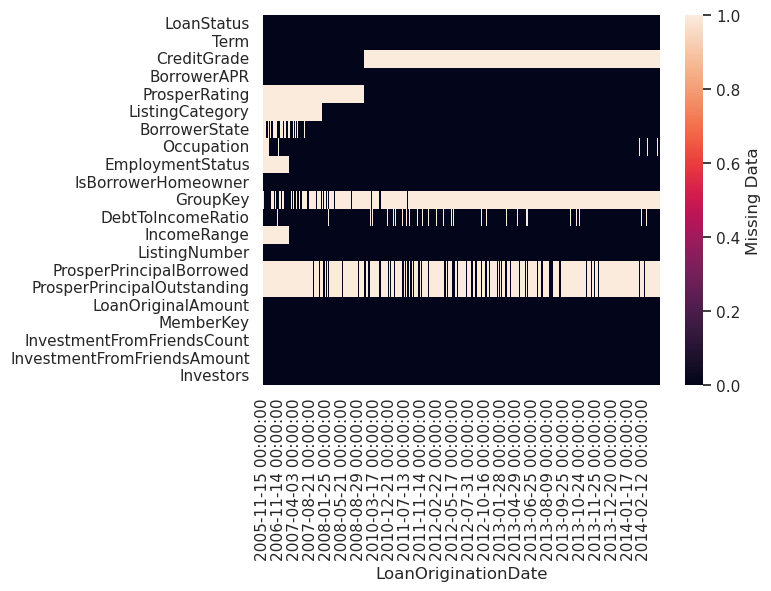

In [434]:
# Replace placeholders with NaN values
df_sub.ListingCategory = df_sub.ListingCategory.replace({0:np.nan})
df_sub.IncomeRange = df_sub.IncomeRange.replace({'Not displayed':np.nan})
df_sub.EmploymentStatus = df_sub.EmploymentStatus.replace({'Not available':np.nan})

# Visualize missing values
sns.heatmap(df_sub.set_index('LoanOriginationDate').sort_index().isna().transpose(),
            cbar_kws={'label':'Missing Data'});

> After assessing our variables of interest it's clear that we have several cleaning tasks to perform:

1. Our analysis doesn't require the granularity present in `LoanStatus`. We can combine the past due category and combine 'FinalPaymentInProgress' with 'Completed'.

2. Our analysis doesn't require the granularity present in `Occupation`. We can group occupations into smaller categories using ISCO grouping standards.

3. Based on the heatmap and their unique values comparison, we can see the `CreditGrade` and `ProsperRating` store the same variables. The two can be melted into one column using the ranking scheme AA - HR.

4. 19.4% of borrowers had exisiting loan balances with Prosper at the time of new loan origination. These pre-existing loan totals are stored in `ProsperPrincipalBorrowed` and `ProsperPrincipalOutstanding`. While in missing value assessment these variables appear to have 80.6% NaN values and qualify for removal, descriptive statistics show that the 19.4% of values have a meaningful value size to warrant keeping them. To deal with the missing values, we can engineer new 'TotalBorrowed' and 'TotalOutstanding' variables by combining the variables above with LoanOriginalAmount. 

5. Our analysis doesn't require the granularity present in `ListingCategory`. To reduce the categories, we'll keep the top 8 (1,7, 2, 3, 6, 4, 13, 15, 18), and lump the remaining in with 'Other'. `ListingCategory` is also only missing values from before 08', but we can't drop these rows and it would be misleading to replace the NaN values with a common value. The best option is to leave the missing category as it was.

7. `IncomeRange` and `EmploymentStatus` weren't recorded prior to 07'. That date range isn't relavent to our analysis, so we can just drop the missing rows along with the remaining NaN values throughout the dataset

6. Remove unnecessary variables:
    - Group Key: Contains more than 70% NaN
    - IsBorrowerHomeowner, MemberKey: Not needed for our analysis


## 2. Data Cleaning

In [435]:
clean_df = df_sub.copy()

### 7. Remove unnecessary variables

In [436]:
clean_df.drop(['GroupKey', 'IsBorrowerHomeowner', 'MemberKey'], axis=1, inplace=True)

### 2. Group Occupation Categories

In [437]:
# Rename Occupation values to ISCO categories using custom mapp
for index, row in clean_df.iterrows():
    clean_df.at[index, 'Occupation'] = custom_funcs.map_occupation_to_isco(row['Occupation'])

In [438]:
isco = ['Professionals', 'Clerical Support', 'Managers', 'Service/Sales',
        'Craft Workers', 'Other', 'Technicians', 'Skilled Agr/Forestry',
        'Operators/Assemblers', 'Armed Forces', 'Elementary']

# Test Occupations were converted
assert(all((clean_df.Occupation.value_counts().index == isco)))


### 1. Combine LoanStatus Categories

In [439]:
clean_df.LoanStatus = clean_df.LoanStatus.replace({'Past Due (1-15 days)': 'Past Due',
                        'Past Due (31-60 days)': 'Past Due',
                        'Past Due (61-90 days)': 'Past Due',
                        'Past Due (91-120 days)': 'Past Due',
                        'Past Due (16-30 days)': 'Past Due',
                        'Past Due (>120 days)': 'Past Due',
                        'FinalPaymentInProgress': 'Completed'})

In [440]:
loan_statuses = ['Current', 'Completed', 'Chargedoff', 'Defaulted',
        'Past Due', 'Cancelled']

# Test loan statuses were converted
assert(all((clean_df.LoanStatus.value_counts().index == loan_statuses)))

### 3. Merge CreditGrade and ProsperRating into one column

In [441]:
# Merge columns
ratings = ['CreditGrade','ProsperRating']
other = clean_df.columns.difference(ratings)
clean_df= clean_df.melt(id_vars = other, value_vars = ratings, 
                        var_name = 'CreditType', value_name = 'CreditRating')

# Drop the redundant null value rows from the merged column
clean_df = clean_df[~clean_df.CreditRating.isnull()]

clean_df[['CreditType', 'CreditRating']]

,CreditType,CreditRating
0,CreditGrade,C
2,CreditGrade,HR
11,CreditGrade,C
17,CreditGrade,AA
21,CreditGrade,D
...,...,...
227869,ProsperRating,C
227870,ProsperRating,A
227871,ProsperRating,D
227872,ProsperRating,C


### 4. Engineer 'TotalBorrowed' and 'TotalOutstanding' variables

In [442]:
# Create TotalBorrowed var
clean_df['TotalBorrowed'] = np.where(clean_df.ProsperPrincipalBorrowed.isna(),
                                clean_df.LoanOriginalAmount,
                                clean_df.ProsperPrincipalBorrowed + clean_df.LoanOriginalAmount)

# Create TotalOutstanding var
clean_df['TotalOutstanding'] = np.where(clean_df.ProsperPrincipalOutstanding.isna(),
                                clean_df.LoanOriginalAmount,
                                clean_df.ProsperPrincipalOutstanding + clean_df.LoanOriginalAmount)

# Drop Prosper values
clean_df.drop(['ProsperPrincipalOutstanding', 'ProsperPrincipalBorrowed'], axis=1, inplace=True)

clean_df[['TotalOutstanding', 'TotalBorrowed']]

,TotalOutstanding,TotalBorrowed
0,9425.00,9425.0
2,3001.00,3001.0
11,1000.00,1000.0
17,10000.00,10000.0
21,3000.00,3000.0
...,...,...
227869,10000.00,10000.0
227870,6815.42,35501.0
227871,10000.00,10000.0
227872,18264.37,20000.0


### 5. Consolidate ListingCategory

In [443]:
# Replace non-interest categories with 7
clean_df.ListingCategory.fillna(0, inplace=True)
clean_df.ListingCategory = clean_df.ListingCategory.replace({5:7, 8:7, 9:7, 10:7, 11:7, 12:7, 14:7, 
                                                    16:7, 17:7, 19:7, 20:7}).astype('int')
# Visually confirm values consolidated and NaN are 0
clean_df.ListingCategory.value_counts() 

ListingCategory
1     58242
0     16965
7     14642
2      7422
3      7172
6      2565
4      2395
13     1996
15     1522
18      885
Name: count, dtype: int64

### 6. Drop NaN values

Prior to dropping values I've decided to further assess the 'Occupation' and 'DebtToIncomeRatio' variables to determine how best to handle their NaN values.

EmploymentStatus
Employed         0.221141
Full-time        0.232639
Not employed     0.985629
Other            0.648713
Part-time        0.371878
Retired          0.962073
Self-employed    0.370799
Name: count, dtype: float64
IncomeRange
$0                1.000000
$1-24,999         0.125327
$100,000+         0.073033
$25,000-49,999    0.071691
$50,000-74,999    0.054475
$75,000-99,999    0.053317
Not employed      0.903226
Name: count, dtype: float64


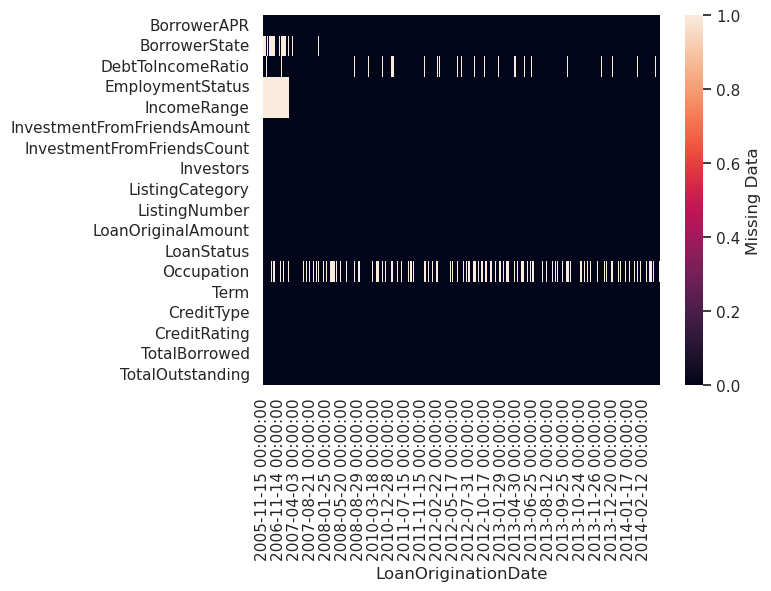

In [444]:
# Visualize missing values
sns.heatmap(clean_df.set_index('LoanOriginationDate').sort_index().isna().transpose(),
            cbar_kws={'label':'Missing Data'});

# Check if Occupation nulls are due to certain employment statuses 
print(clean_df.query('Occupation.isnull()').EmploymentStatus.value_counts() / clean_df.EmploymentStatus.value_counts())

# Check if DebtToIncomeRatio nulls are due to $0 income
print(clean_df.query('DebtToIncomeRatio.isnull()').IncomeRange.value_counts() / clean_df.IncomeRange.value_counts())


> It's likely some null values for DebtToIncomeRatio are due to "divide by zero" errors when there is no income. We will replace these values with 1.

In [445]:
# Check descriptive stats prior to replacement
print(clean_df.DebtToIncomeRatio.describe())

# Replace Self-Employed DebtToIncomeRatio with mean of those individuals .fillna(mean_self_dir, inplace=True)
fill_df = clean_df.loc[(clean_df.IncomeRange == "$0") | (clean_df.IncomeRange == "Not employed"), 
                        ['DebtToIncomeRatio']].fillna({'DebtToIncomeRatio':1})

clean_df.loc[(clean_df.IncomeRange == "$0") | (clean_df.IncomeRange == "Not employed"), 
                        ['DebtToIncomeRatio']] = fill_df

# Compare descriptive stats after
print(clean_df.DebtToIncomeRatio.describe())

count    105263.000000
mean          0.275976
std           0.551811
min           0.000000
25%           0.140000
50%           0.220000
75%           0.320000
max          10.010000
Name: DebtToIncomeRatio, dtype: float64
count    106612.000000
mean          0.285138
std           0.554249
min           0.000000
25%           0.144162
50%           0.220000
75%           0.320000
max          10.010000
Name: DebtToIncomeRatio, dtype: float64


> It appears Occupation nulls are disproportionately due to unemployed and retired individuals not having an occupation. We will create an unemployed category to account for them.

In [446]:
# Replace occupation where employment status is not employed or retired 

fill_df = clean_df.loc[(clean_df.EmploymentStatus == "Retired") | (clean_df.IncomeRange == "Not employed"), 
                        ['Occupation']].fillna({'Occupation':'No Occupation'})
clean_df.loc[(clean_df.EmploymentStatus == "Retired") | (clean_df.IncomeRange == "Not employed"), 
                        ['Occupation']] = fill_df

# Visually verify values were updated
clean_df.Occupation.value_counts()

Occupation
Professionals           38935
Clerical Support         8926
Managers                 8455
Service/Sales            8099
Craft Workers            6180
Other                    3802
Technicians              2376
Skilled Agr/Forestry     2234
Operators/Assemblers     2185
Armed Forces             1616
Elementary               1595
No Occupation            1556
Name: count, dtype: int64

In [447]:
# Drop missing values
clean_df.dropna(inplace=True)

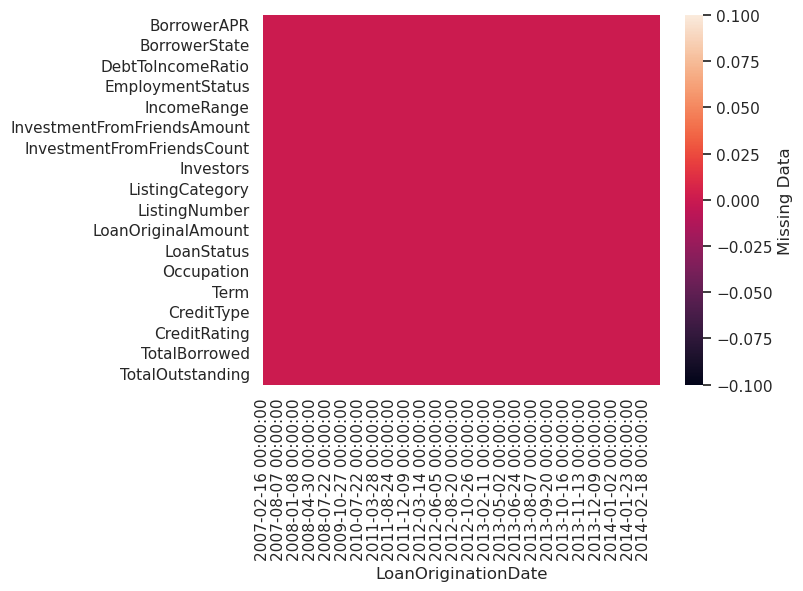

In [448]:
# Confirm all missing values were removed
sns.heatmap(clean_df.set_index('LoanOriginationDate').sort_index().isna().transpose(),
            cbar_kws={'label':'Missing Data'});

## 3. Store Data

In [449]:
# save the clean copy
clean_df.to_csv('../data/prosperLoanData_clean_v1.csv', index = False)

## 4. Import Clean Data & Define Structure

> There are 74,019 loan listings in the dataset with 18 variables (excluding the ID variable for identifying loan listings) for our exploration. The variables are almost split between qualitative and quantitative. Of the quantitative features, there is one date (Loan Origination), two discrete (Term, InvestmentFromFriendsCount), and the rest are continuous. Of the qualitative, 2 are ordinal (IncomeRange, CreditRating), while the remaining are nominal.

### What is/are the main feature(s) of interest in your dataset?

> We aim to focus on examining aspects related to borrower demographics, loan listings, various time periods, and the impact of friend investors. Our goal is to explore how these factors influence the distribution of loan listings and comprehend the impact of significant events like the 08' Recession, the SEC's cease and desist order against Prosper Marketplace in 09', and the subsequent period following the SEC relaunch on Prosper's loan listings.

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

> Borrow Demographics
- BorrowerState
- EmploymentStatus
- IncomeRange
- Occupation
- CreditRating
> Loan Listings
- BorrowerAPR
- DebtToIncomeRatio
- ListingCategory
- LoanOriginalAmount
- LoanOriginationDate
- TotalBorrowed
- TotalOutstanding
- Term
> Significant historic events
- CreditType
- LoanOriginationDate
> Lender Impact
- InvestmentFromFriendsAmount
- InvestmentFromFriendsCount
- Investors

### Import Data

In [450]:
# load the clean dataset
df = pd.read_csv('../data/prosperLoanData_clean_v1.csv')

df.LoanOriginationDate = pd.to_datetime(df.LoanOriginationDate)

In [451]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74019 entries, 0 to 74018
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   BorrowerAPR                  74019 non-null  float64       
 1   BorrowerState                74019 non-null  object        
 2   DebtToIncomeRatio            74019 non-null  float64       
 3   EmploymentStatus             74019 non-null  object        
 4   IncomeRange                  74019 non-null  object        
 5   InvestmentFromFriendsAmount  74019 non-null  float64       
 6   InvestmentFromFriendsCount   74019 non-null  int64         
 7   Investors                    74019 non-null  int64         
 8   ListingCategory              74019 non-null  int64         
 9   ListingNumber                74019 non-null  int64         
 10  LoanOriginalAmount           74019 non-null  int64         
 11  LoanOriginationDate          74019 non-nu

In [452]:
# Convert BorrowerAPR to percent
df['APRPct'] = df.BorrowerAPR.apply(lambda x: x * 100)

# Convert credit types to relevant time period
df.CreditType.replace({'CreditGrade':'Before 2009-07','ProsperRating':'After 2009-07'}, inplace=True)
df.rename({'CreditType':'TimePeriod'}, axis=1, inplace=True)

# Map Listing Category codes to value names  
df.ListingCategory.replace({0:'No Occupation', 1:'Debt Consolidation', 2:'Home Improvement',
                        3:'Business', 4:'Personal', 6:'Auto', 7:'Other', 13:'Household' , 15:'Medical' , 18:'Taxes' },inplace=True)   

df[['APRPct', 'TimePeriod', 'ListingCategory']].sample(3)

,APRPct,TimePeriod,ListingCategory
16927,18.637,After 2009-07,Debt Consolidation
4626,8.684,Before 2009-07,Home Improvement
49096,39.153,After 2009-07,Debt Consolidation


In [453]:
# Convert IncomeRange dtype to ordered category
IR_cat = pd.CategoricalDtype(categories=['Not employed', '$0', '$1-24,999', '$25,000-49,999',
                                                '$50,000-74,999', '$75,000-99,999', '$100,000+'], 
                                                ordered=True)
df.IncomeRange = df.IncomeRange.astype(IR_cat)

# Convert CreditRating dtype to ordered category
CR_cat = pd.CategoricalDtype(categories=['HR', 'E', 'D', 'C', 'B', 'A', 'AA'], ordered=True)
df.CreditRating = df.CreditRating.astype(CR_cat)

# Convert LoanStatus dtype to ordered category
LS_cat = pd.CategoricalDtype(categories=['Completed', 'Current', 'Past Due', 'Defaulted', 
                                        'Chargedoff'], ordered=True)
df.LoanStatus = df.LoanStatus.astype(LS_cat)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74019 entries, 0 to 74018
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   BorrowerAPR                  74019 non-null  float64       
 1   BorrowerState                74019 non-null  object        
 2   DebtToIncomeRatio            74019 non-null  float64       
 3   EmploymentStatus             74019 non-null  object        
 4   IncomeRange                  74019 non-null  category      
 5   InvestmentFromFriendsAmount  74019 non-null  float64       
 6   InvestmentFromFriendsCount   74019 non-null  int64         
 7   Investors                    74019 non-null  int64         
 8   ListingCategory              74019 non-null  object        
 9   ListingNumber                74019 non-null  int64         
 10  LoanOriginalAmount           74019 non-null  int64         
 11  LoanOriginationDate          74019 non-nu

## 5. Data Exploration

In [454]:
# Set plot bckgd to white
sns.set_theme(style="white")

# Create primary color for use in plots
color = sns.color_palette("Blues")[4]


### Univariate Analysis

> **What states are the borrowers from?**

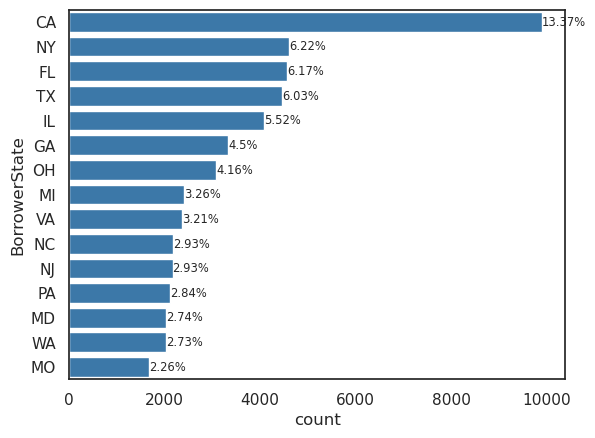

In [455]:
# Counts for top 15 states
st_cnt = df.BorrowerState.value_counts()[0:15]

# % of total for states
st_pct = df.BorrowerState.value_counts(normalize=True)*100

# Plot counts ordered by frequency
sns.countplot(data=df, y="BorrowerState", order=df.BorrowerState.value_counts().iloc[:15].index, color=color);

# Append % values as text to bars
for i, count in enumerate(st_cnt):
    pct_str = '{}%'.format(st_pct[i].round(2))
    plt.text(count+1, i, pct_str, va='center', size='x-small');


We can see that of the 15 states with the most borrowers, California had the most (13.37%) and Missouri had the least (2.26%.)

> **What is the distribution of DebtToIncomeRatio across loan listings?**

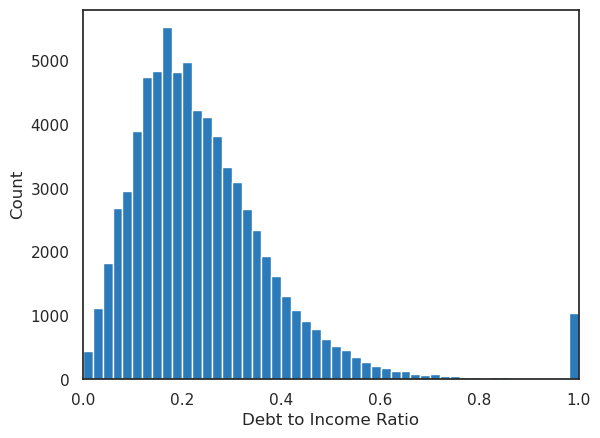

In [456]:
# Plot histogram
plt.hist(data=df, x='DebtToIncomeRatio', bins=500, color=color)

# Set x-axis range to distribution range
plt.xlim(xmin=0, xmax = 1)

# Append labels
plt.ylabel('Count')
plt.xlabel('Debt to Income Ratio');

From the histogram we see that `Debt To Income Ratio` is slightly right-skewed with a mode slightly less than 0.2 and mean of .27. There are a number of outliers because we assigned the value of 1.0 to individuals without a source of income.

> **What is the typical employment status for borrowers?**

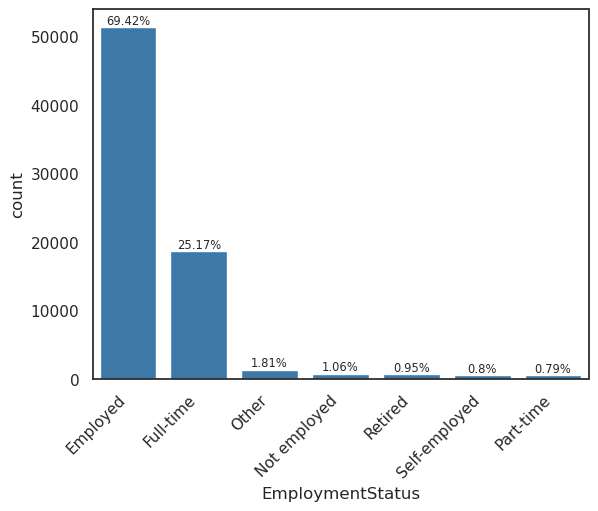

In [457]:
# Counts for statuses
emp_cnt = df.EmploymentStatus.value_counts()

# % of total for statuses
emp_pct = df.EmploymentStatus.value_counts(normalize=True)*100
emp_pct = emp_pct.round(2)

# Plot bar chart for employment status
sns.countplot(data=df, x="EmploymentStatus", color=color, order=emp_cnt.index)

# Rotate x labels to fit
plt.xticks(rotation=45, ha='right');

# Append % values as text to bars
for i, count in enumerate(emp_cnt):
    pct_str = '{}%'.format(emp_pct[i])
    plt.text(i, count, pct_str, va='bottom', ha='center', size='x-small');

We can easily see that `retired` and `not employed`` individuals make up only 2% of borrower and likely aren't the reason behind defaulted loans. 

Unfortunately we can't segment the `employed` and can't use this bar plot to learn anything about the true distribution between `full-time`, `part-time`, and `self-employed`. With more time, we could remove the `Employed` rows and look at a subset of the data to explore further. 

For the remainder of the exploration we'll combine `Full-Time`, `Part-Time`, and `Self-Employed`.

In [458]:
# Consolidate employment variable
df.EmploymentStatus = df.EmploymentStatus.replace({'Self-employed': 'Employed',
                        'Full-time': 'Employed', 'Part-time': 'Employed'})

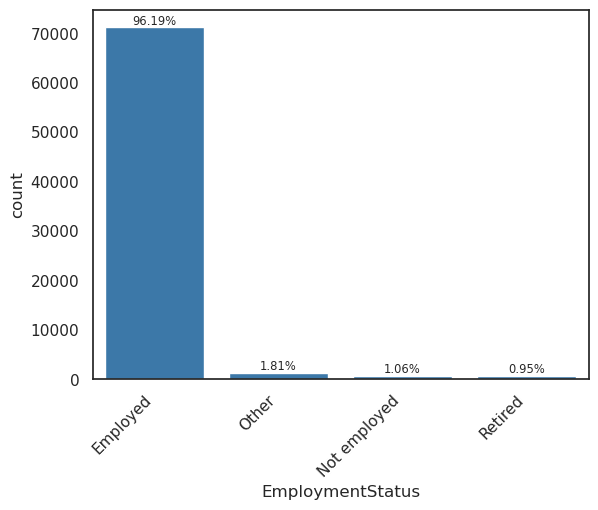

In [459]:
# Repeat of previous plot to review employment grouping
emp_cnt = df.EmploymentStatus.value_counts()
emp_pct = df.EmploymentStatus.value_counts(normalize=True)*100
emp_pct = emp_pct.round(2)

sns.countplot(data=df, x="EmploymentStatus", color=color, order=emp_cnt.index)
plt.xticks(rotation=45, ha='right');

for i, count in enumerate(emp_cnt):
    pct_str = '{}%'.format(emp_pct[i])
    plt.text(i, count, pct_str, va='bottom', ha='center', size='x-small');

> **What is the typical Income Range of borrowers?**

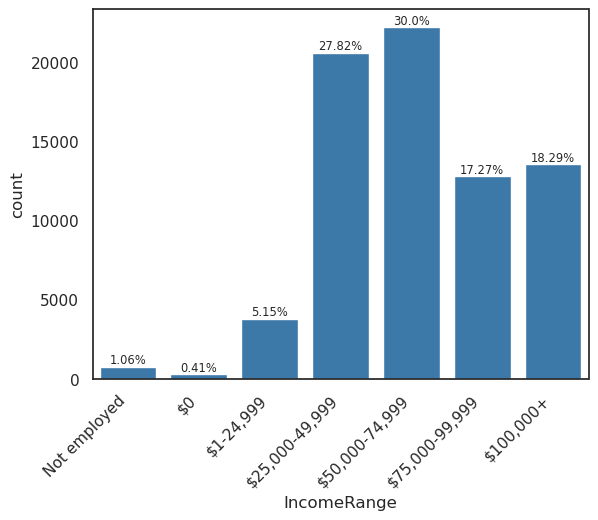

In [460]:
# Counts for income ranges, sort maintains ordinal order
ir_cnt = df.IncomeRange.value_counts(sort=False)

# % of total for ranges
ir_pct = df.IncomeRange.value_counts(normalize=True, sort=False)*100
ir_pct = ir_pct.round(2)

# Plot bar chart
sns.countplot(data=df, x="IncomeRange", color=color)

# Rotate x labels to fit
plt.xticks(rotation=45, ha='right');

# Append % values as text to bars
for i, count in enumerate(ir_cnt):
    pct_str = '{}%'.format(ir_pct[i])
    plt.text(i, count, pct_str, va='bottom', ha='center', size='x-small');

Only 6.5% of borrowers make less than 25k per year. More than half (58%) of borrowers make between 25k and 75k. Not as many borrowers make more than 75k (35.5%).  

> **For loans where friends lended, what was the distribution of amounts lent by friends?**

(1375, 20)

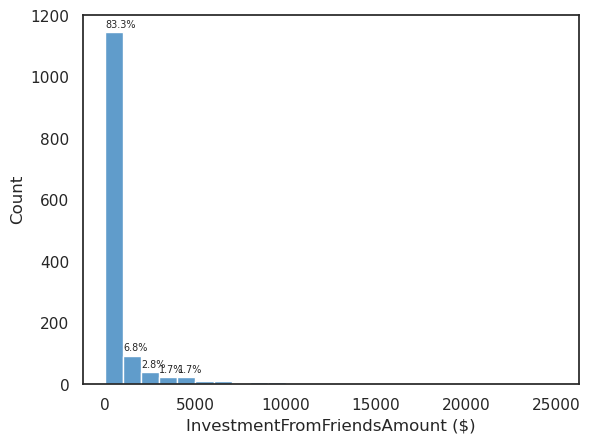

In [461]:
# Get subset where at least one friend was lender
all_friends = df.query('InvestmentFromFriendsCount > 0')

# Plot histogram of friend investment amounts
g = sns.histplot(data=all_friends, x='InvestmentFromFriendsAmount', bins=25, color=color)

# Append % totals to each bar
for p in g.patches:
    pct = (p.get_height()/all_friends.shape[0]*100).round(1)
    if pct > 1:
        txt = str(pct) + '%'
        txt_x = p.get_x()
        txt_y = p.get_height()
        g.text(txt_x,txt_y+15,txt, size = 'xx-small')

# Label axes
plt.ylabel('Count')
plt.xlabel('InvestmentFromFriendsAmount ($)');

#Check shape of subset
all_friends.shape


(1133, 20)

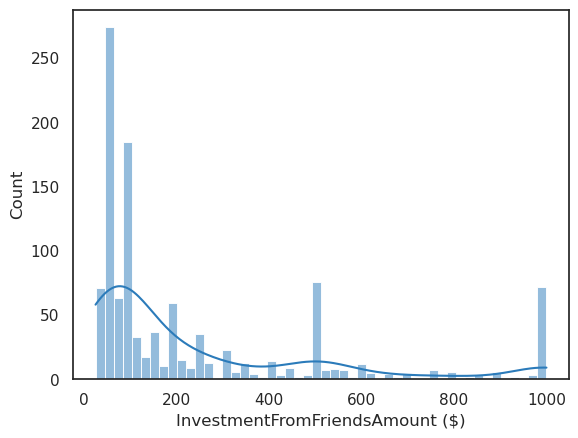

In [462]:
# Get zoomed subset where at least one friend was lender and amount was less than $1001
friends_less_1100 = df.query('(InvestmentFromFriendsCount > 0) & (InvestmentFromFriendsAmount < 1001)')

# Plot histogram(KDE) of friend investment amounts
sns.histplot(data=friends_less_1100, x='InvestmentFromFriendsAmount', bins=50, color=color, kde=True)

# Label axes
plt.ylabel('Count')
plt.xlabel('InvestmentFromFriendsAmount ($)');

#Check shape of subset
friends_less_1100.shape


The histograms are extremely right-skewed, with a mean of $854 and mode of $50. This is inline with our expectation that less people are willing/able to lend larger sums of money. The highest frequency at 83.3% has listing amounts between $25 and $1000, after which the second highest frequency drops steeply to 6.8% which has listing amounts between $1000 and $2000. Only 3% of loans had friends contribute more than $5000.

If we zoom into the first bin we can see the histogram continues to be extremely right skewed, and that lending amounts tend to fall on convenient increments (50, 100, 200, 500, 1000). Surprisingly, $500 occurred just as frequently as $1000. 

If we further explore this distribution, it could be a contender for log scaling. 

> **What is the distribution of loan categories?**

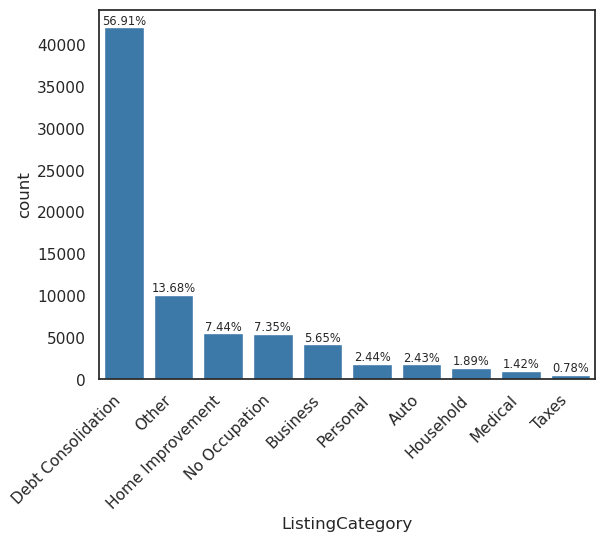

In [463]:
# Counts for categories, sliced for enumerate
lcat_cnt = df.ListingCategory.value_counts()

# % of total for categories
lcat_pct = df.ListingCategory.value_counts(normalize=True)*100
lcat_pct = lcat_pct.round(2)

# Plot bar chart for listing categories
sns.countplot(data=df, x="ListingCategory", color=color, order=lcat_cnt.index)

# Rotate x labels to fit
plt.xticks(rotation=45, ha='right');

# Append % values as text to bars
for i, count in enumerate(lcat_cnt):
    pct_str = '{}%'.format(lcat_pct[i])
    plt.text(i, count, pct_str, va='bottom', ha='center', size='x-small');

The most common loan category was `debt consolidation`, which accounted for 57% of loans. The second largest was `Other` at 13.7% (21% if you include `no occupation`), which is a modest size but we can't tell the real categories of this group. `Home Improvement` and `Business` were the next two most frequent categories, albeit much less common at 7.4% and 5.7% respectively.

> **What are the most common occupations of borrowers?**

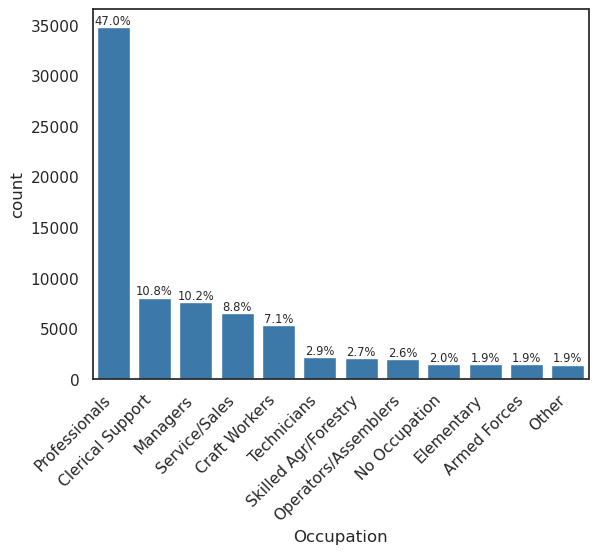

In [464]:
# Counts for occupations
o_cnt = df.Occupation.value_counts()

# % of total for occupations
o_pct = df.Occupation.value_counts(normalize=True)*100
o_pct = o_pct.round(1)

# Plot bar chart for occupations
sns.countplot(data=df, x="Occupation", color=color, order=o_cnt.index)

# Rotate x labels to fit
plt.xticks(rotation=45, ha='right');

# Append % values as text to bars
for i, count in enumerate(o_cnt):
    pct_str = '{}%'.format(o_pct[i])
    plt.text(i, count, pct_str, va='bottom', ha='center', size='x-small');

The largest category of borrowers falls under `Professional`, constituting 47% of the total. Following this, the categories `Clerical Support` and `Managers` have close to the same frequency at 10.8% and 10.2% respectively. 

> What is the distribution of credit ranking across borrowers?

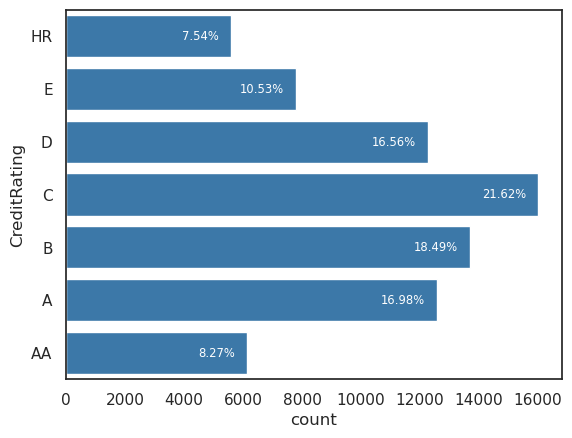

In [465]:
# Counts for ratings
cr_cnt = df.CreditRating.value_counts(sort=False)

# % of total for ratings
cr_pct = df.CreditRating.value_counts(normalize=True, sort=False)*100
cr_pct = cr_pct.round(2)

# Plot bar chart for credit ratings
sns.countplot(data=df, y="CreditRating", color=color)

# Append % values as text to bars
for i, count in enumerate(cr_cnt):
    pct_str = '{}%'.format(cr_pct[i])
    plt.text(count-400, i, pct_str, va='center', ha='right', size='x-small', color='white');

Credit Ratings follow an approximately normal distribution, with a credit rating of C being most frequent (21.6%)

> What is the LoanStatus of borrowers?


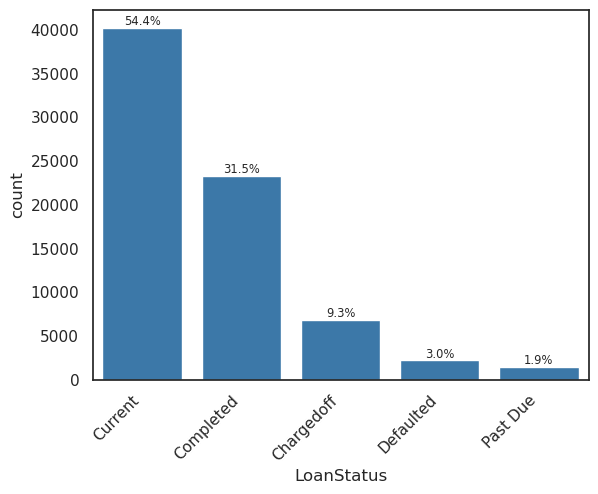

In [466]:
# Counts for statuses
s_cnt = df.LoanStatus.value_counts()

# % of total for statuses
s_pct = df.LoanStatus.value_counts(normalize=True)*100
s_pct = s_pct.round(1)

# Plot bar chart for status of loans
sns.countplot(data=df, x="LoanStatus", color=color, order=s_cnt.index)

# Rotate x labels to fit
plt.xticks(rotation=45, ha='right');

# Append % values as text to bars
for i, count in enumerate(s_cnt):
    pct_str = '{}%'.format(s_pct[i])
    plt.text(i, count, pct_str, va='bottom', ha='center', size='x-small');

It's clear that a majority of loans (54.4%) are `Completed`, but oddly `Charged Off` and `Defaulted` statuses seem extremely high (40.8% combined). Taking into account that a majority of borrowers have higher incomes and medium-great credit ratings, it is worth exploring what could be causing such high delinquincy rates.


> **What is the distribution of loan amount across borrowers?**

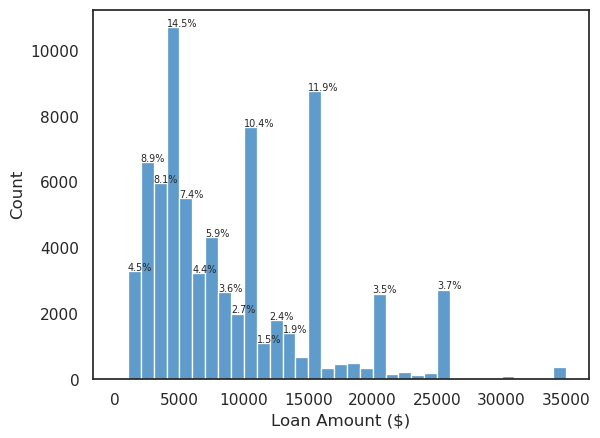

In [467]:
#Set Bins
bins = np.arange(0, df.LoanOriginalAmount.max()+1000, 1000)

# Plot histogram of loan amounts
g = sns.histplot(data=df, x='LoanOriginalAmount', bins=bins, color=color)

# Append % totals to each bar
for p in g.patches:
    pct = (p.get_height()/df.shape[0]*100).round(1)
    if pct > 1:
        txt = str(pct) + '%'
        txt_x = p.get_x()
        txt_y = p.get_height()
        g.text(txt_x,txt_y+15,txt, size = 'xx-small')

# Label axes
plt.ylabel('Count')
plt.xlabel('Loan Amount ($)');

The data is clearly right-skewed and supports the fact that listing frequencies typically drop as listing values increase.

There's an interesting pattern though amongst loan amounts in increments of $5000. While frequency drops significantly between $5k and $10k, loans for $10k are the thrid most frequent amount. Even more surprising, loans of $15k are the second most frequent!

> How frequent are different loan terms?

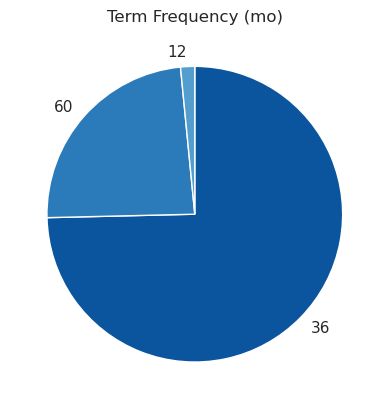

In [468]:
sorted_terms = df.Term.value_counts()

plt.pie(sorted_terms, labels = sorted_terms.index, startangle = 90, counterclock = False, 
        colors=sns.color_palette('Blues_r'))

plt.title('Term Frequency (mo)');
plt.savefig('../plots/term_pie.png');



### Univariate Evaluation

**Distribution(s) of variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?**

> - The findings revealed that the majority of loan listings were intended for debt consolidation, with most borrowers being professionals, the highest concentration of listings coming from California, and a typical income range of $25k-75k.
> - `Charged Off` and `Defaulted` made up a much higer portion of loan statuses than to be expected (40.8% combined). This is worth exploring further.
> - The tendency for loans to be taken out in multiples of $5k and the fact that loans of $15k and $10k are the second and thrid most frequent was fascinating.

**Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?**

> - Converted BorrowerAPR to percent for readability
> - Converted credit types to relevant time periods in order to help explore historical impacts.
> - Mapped Listing Category codes to value names for readability 
> - Converted IncomeRange and CreditRating to ordered Catigorical data types in order to preserve sorting on graphs.
> - Converted LoanStatus to ordered Catigorical data type in order of severity in order to compare visuals more easily

### Bivariate Analysis

> What is the relationship between the amount friends invest and loan status? 

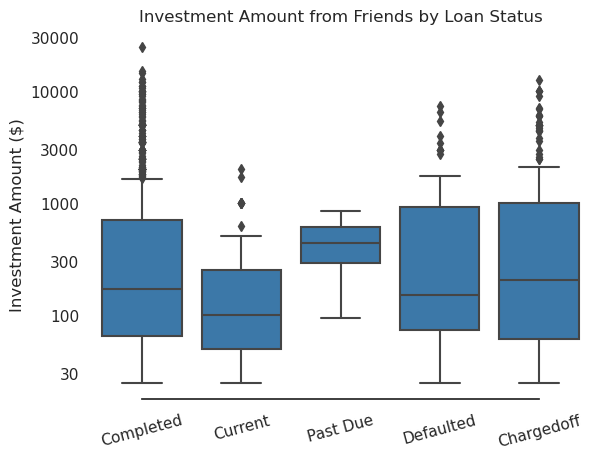

In [469]:
# Plot boxplot
ax1 = sns.boxplot(data=all_friends, x='LoanStatus', y='InvestmentFromFriendsAmount', color=color)

# Transform yscale to log 
ax1.set_yscale("log")
ticks = [30, 100, 300, 1000, 3000, 10000, 30000]
labels = [f'{v}' for v in ticks]
plt.yticks(ticks, labels);

# Labels & Title
plt.xticks(rotation=15)
plt.title('Investment Amount from Friends by Loan Status')
plt.ylabel('Investment Amount ($)')
plt.xlabel('')

# Remove bounding box
sns.despine(trim=True, left=True);

Due to the severe difference in scale of the values, I transformed the dat to log scale. Current loans have a much tighter range than 'Defaulted' or 'Chargedoff' loans. Past due loans have an even tighter spread, but that could be due to limited number of past due loans. 

> What is the relationship between Borrower APR and loan status? 

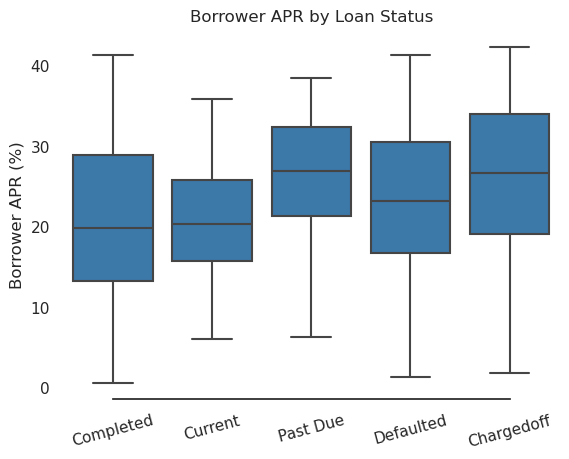

In [470]:
# Plot boxplot
ax1 = sns.boxplot(data=df, x='LoanStatus', y='APRPct', color=color)


# Labels & Title
plt.xticks(rotation=15)
plt.title('Borrower APR by Loan Status')
plt.ylabel('Borrower APR (%)')
plt.xlabel('')

# Remove bounding box
sns.despine(trim=True, left=True);

Given that charged off loans are worse than defaulted loans, it's not surprising that charged off loans have a higher mean borrower apr and IQR than defaulted loans. This is also true of the defaulted loans compared to completed loans. 

> What is the relationship between Debt to Income Ratio and loan status? 

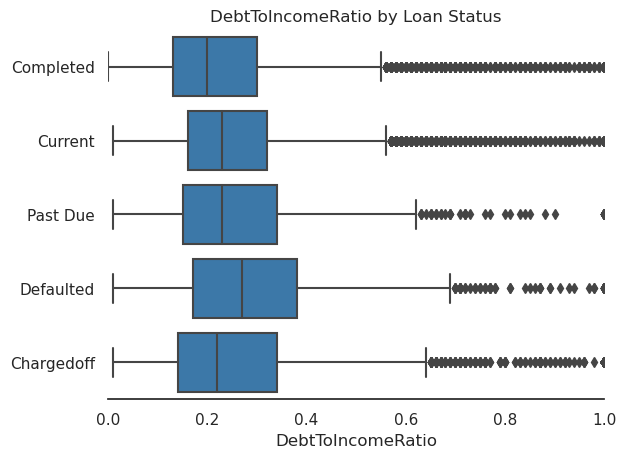

In [471]:
# Plot boxplot
ax1 = sns.boxplot(data=df, y='LoanStatus', x='DebtToIncomeRatio', color=color)
plt.xlim(xmin=0, xmax = 1)


# Labels & Title
plt.title('DebtToIncomeRatio by Loan Status')
plt.xlabel('DebtToIncomeRatio')
plt.ylabel('')

# Remove bounding box
sns.despine(trim=True, left=True);

75% of all loans have a debt to income ratio of less than .4. Unlike our previous two comparisons, defaulted loans have a higher mean debt to income ratio compared to charged off loans, but they both still have higher Q3s and means than completed and current loans (by ~10%).

> Is there a correlation between debt to income ratio and total amount borrowed?

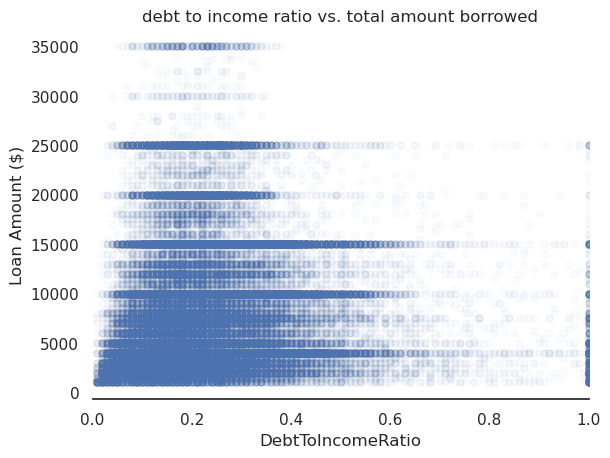

In [472]:
# Plot scatterplot
plt.scatter(data=df, x='DebtToIncomeRatio', y='LoanOriginalAmount', alpha=0.025, s=25)
plt.xlim(xmin=0, xmax = 1)

# Labels & Title
plt.ylabel('Loan Amount ($)')
plt.xlabel('DebtToIncomeRatio')
plt.title('debt to income ratio vs. total amount borrowed')

# Remove bounding box
sns.despine(trim=True, left=True);

Loans of $5k, $10k, and $15k seem to have similar spreads of debt to income ratio. Past $20k this stops and we see debt to income staying below .4 for the most part.

> Is there any variation in Loan Status distribution across listing categories?

/home/tristenwallace/anaconda3/envs/udacity/lib/python3.11/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


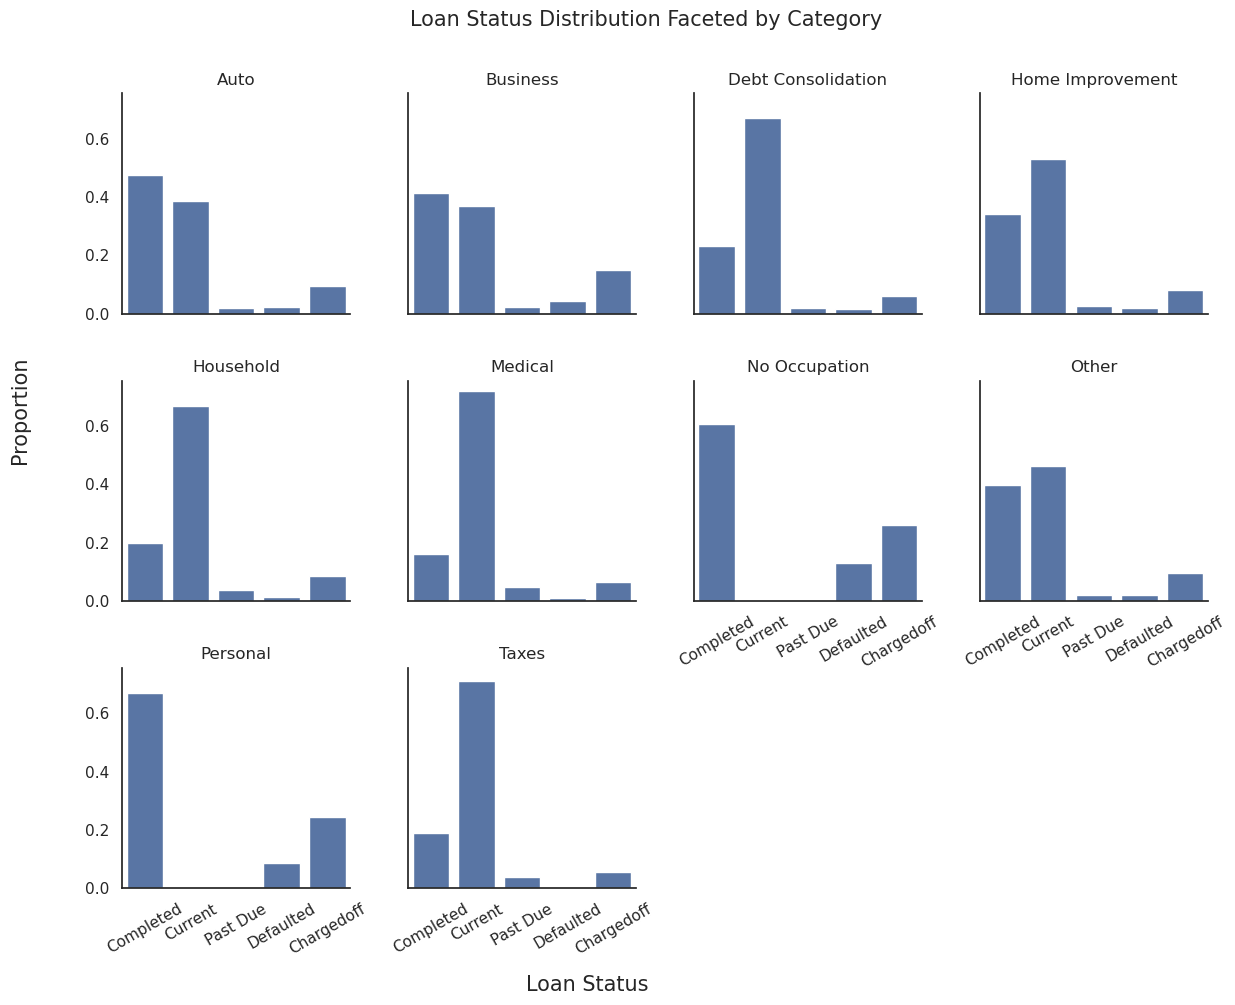

In [492]:
# Create LoanStatus distributions grouped by ListingCategory
cat_proportions = df.groupby(['ListingCategory'])['LoanStatus'].value_counts(normalize=True)
cat_proportions = cat_proportions.reset_index(drop=False)

# Plot faceted bar plots
g = sns.FacetGrid(cat_proportions, col='ListingCategory', col_wrap=4)
g.map(sns.barplot, 'LoanStatus', 'proportion')

# Rotate x ticks for legibility
for axis in g.axes.flat:
    axis.tick_params(axis='x', labelrotation=30)

# Set titles and labels
g.set_titles('{col_name}')
g.set(xlabel='', ylabel='')
plt.suptitle("Loan Status Distribution Faceted by Category", fontsize=15, y=1.05)
g.fig.text(0.4, -0.04, s='Loan Status',fontdict={'fontsize':15})
g.fig.text(-0.03, 0.55, s='Proportion',fontdict={'fontsize':15}, rotation = 90);

The first interesting thing is that the categories 'Personal' and 'No Occupation' likely have no 'Current' status. This warrants exploring these variables compared to LoanOriginationDate. It could have something to do with their higher distribution of 'defaulted' and 'charged off' loans. Following those categories, Business loans have the next highest proportion off 'Charged off' loans and are still current.



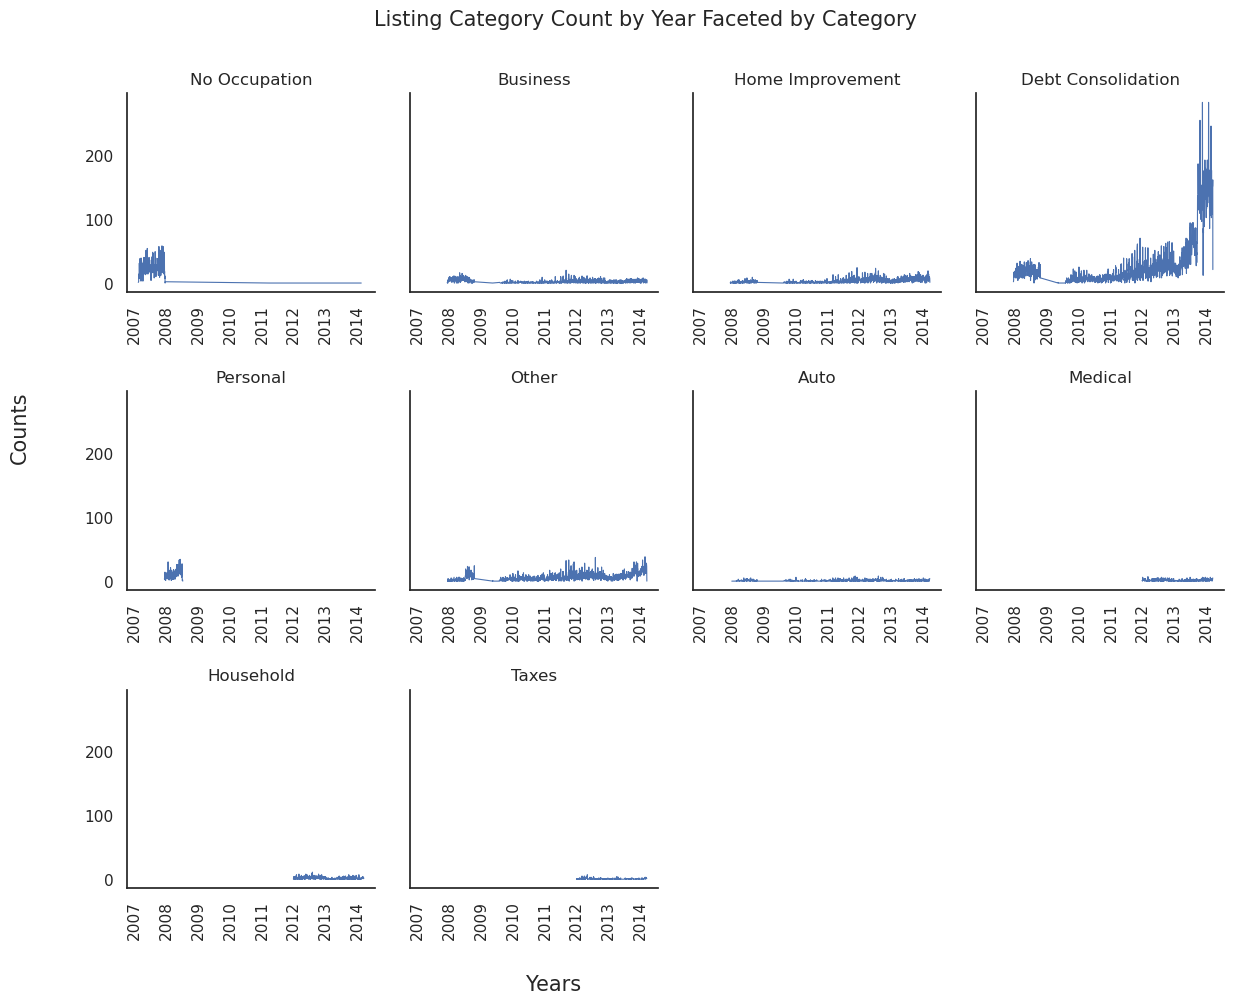

In [537]:
cat_dates = df.groupby(['LoanOriginationDate', 'ListingCategory']).size()
cat_dates = cat_dates.reset_index(drop=False)
cat_dates.rename(columns={0:'counts'}, inplace=True)


# Plot faceted bar plots
g = sns.FacetGrid(cat_dates, col='ListingCategory', col_wrap=4)
g.map(sns.lineplot, 'LoanOriginationDate', 'counts', linewidth = .8)
plt.subplots_adjust(hspace=0.5)


# Rotate x ticks for legibility
for axis in g.axes.flat:
    axis.tick_params(axis='x', labelrotation=90, labelbottom=True)

# Set titles and labels
g.set_titles('{col_name}')
g.set(xlabel='', ylabel='')
plt.suptitle("Listing Category Count by Year Faceted by Category", fontsize=15, y=1.05)
g.fig.text(0.4, -0.04, s='Years',fontdict={'fontsize':15})
g.fig.text(-0.03, 0.55, s='Counts',fontdict={'fontsize':15}, rotation = 90);

The faceted timelines above confirm our suspitions about the "Personal" and "No Occupation" categories; they both ceased to exist in 2008. 

It's also clear something weird was going on in 2009, possibly related to the end of the "Personal" category.The end of that catagory corresponds with a severe dip in the catagorization of other catagories and likely loans overall (but we'd have to check). Some other mildly interesting facts include the creation of several new catagories in 2012 and the explosion of "Debt Consolidation" loans from 2013-2014.

### Bivariate Evaluation

**How did the feature(s) of interest vary with other features in the dataset?**

> By comparing Loan Status to several different features we found that "Charged Off" and "Defaulted" loans had on average a higer debt to income ratio and Borrower APR than "Completed" or "Current" loans. 
> We discovered two interesting things about two specific Listing Catagories: "Personal" and "No Occupation"  
> - They had a higher proportion of "Charged Off" and "Defaulted" loans (more than 20% higher in most cases).
> - They accounted for 9.8% of all loans, but only existed between 2007 and 2008.

